In [2]:
id_ = 'core'
backup_dir = '/root/datos/maestria/netopaas/luca/data/atlas/'


# UTX (KDM6A) and KMT2D in Proto and Anti Oncogenicity

## Import

In [49]:
import pandas as pd
import numpy as np
import scipy as scp

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import anndata as ad
import scanpy as sc

In [4]:
adata = sc.read_h5ad(f'{backup_dir}/{id_}.h5ad')

In [5]:
adata.obs.groupby('tumor_stage').size()

/tmp/ipykernel_72651/226547110.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('tumor_stage').size()


tumor_stage
advanced      245051
early         379059
nan               43
non-cancer    268143
dtype: int64

## Heatmaps of cell types

In [140]:
adata.obs.origin

001C_AAACCTGCATCGGGTC-0           normal
001C_AAACCTGTCAACACCA-0           normal
001C_AAACGGGAGACTAAGT-0           normal
001C_AAACGGGAGGCTCATT-0           normal
001C_AAACGGGAGGGAACGG-0           normal
                               ...      
bcBOGU_25-21               tumor_primary
bcHDOT_25-21               tumor_primary
bcIFTF_25-21               tumor_primary
bcBDLT_25-21               tumor_primary
bcBNMZ_25-21               tumor_primary
Name: origin, Length: 892296, dtype: category
Categories (5, object): ['nan', 'normal', 'normal_adjacent', 'tumor_metastasis', 'tumor_primary']

In [100]:
adata_normal_tumor = adata[(adata.obs.origin == 'tumor_primary') & (adata.obs.final_pred == 'Normal')]
print(adata_normal_tumor.shape)

adata_normal_normal = adata[(adata.obs.origin == 'normal_adjacent') & (adata.obs.final_pred == 'Normal')]
print(adata_normal_normal.shape)

adata_tumor_tumor = adata[(adata.obs.origin == 'tumor_primary') & (adata.obs.final_pred == 'Tumor')]
print(adata_tumor_tumor.shape)

(33768, 18450)
(20669, 18450)
(1841, 18450)


Since there is only one cell in fibroblast for tumor we remove it to avoid erros

In [103]:
adata_tumor_tumor.obs.groupby('Level_2_transfered_label').size()

/tmp/ipykernel_1376/3884537970.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_tumor_tumor.obs.groupby('Level_2_transfered_label').size()


Level_2_transfered_label
Airway epithelium      1304
Alveolar epithelium      39
Blood vessels           189
Fibroblast lineage        1
Lymphoid                 14
Myeloid                   5
Unknown                 286
dtype: int64

In [105]:
adata_tumor_tumor = adata_tumor_tumor[adata_tumor_tumor.obs['Level_2_transfered_label'] != 'Fibroblast lineage']
adata_tumor_tumor.obs.groupby('Level_2_transfered_label').size()

/tmp/ipykernel_1376/3807538772.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_tumor_tumor.obs.groupby('Level_2_transfered_label').size()


Level_2_transfered_label
Airway epithelium      1304
Alveolar epithelium      39
Blood vessels           189
Lymphoid                 14
Myeloid                   5
Unknown                 286
dtype: int64

In [106]:
sc.tl.rank_genes_groups(adata_normal_tumor, 'Level_2_transfered_label', method='wilcoxon')
sc.tl.rank_genes_groups(adata_normal_normal, 'Level_2_transfered_label', method='wilcoxon')
sc.tl.rank_genes_groups(adata_tumor_tumor, 'Level_2_transfered_label', method='wilcoxon')

/usr/local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


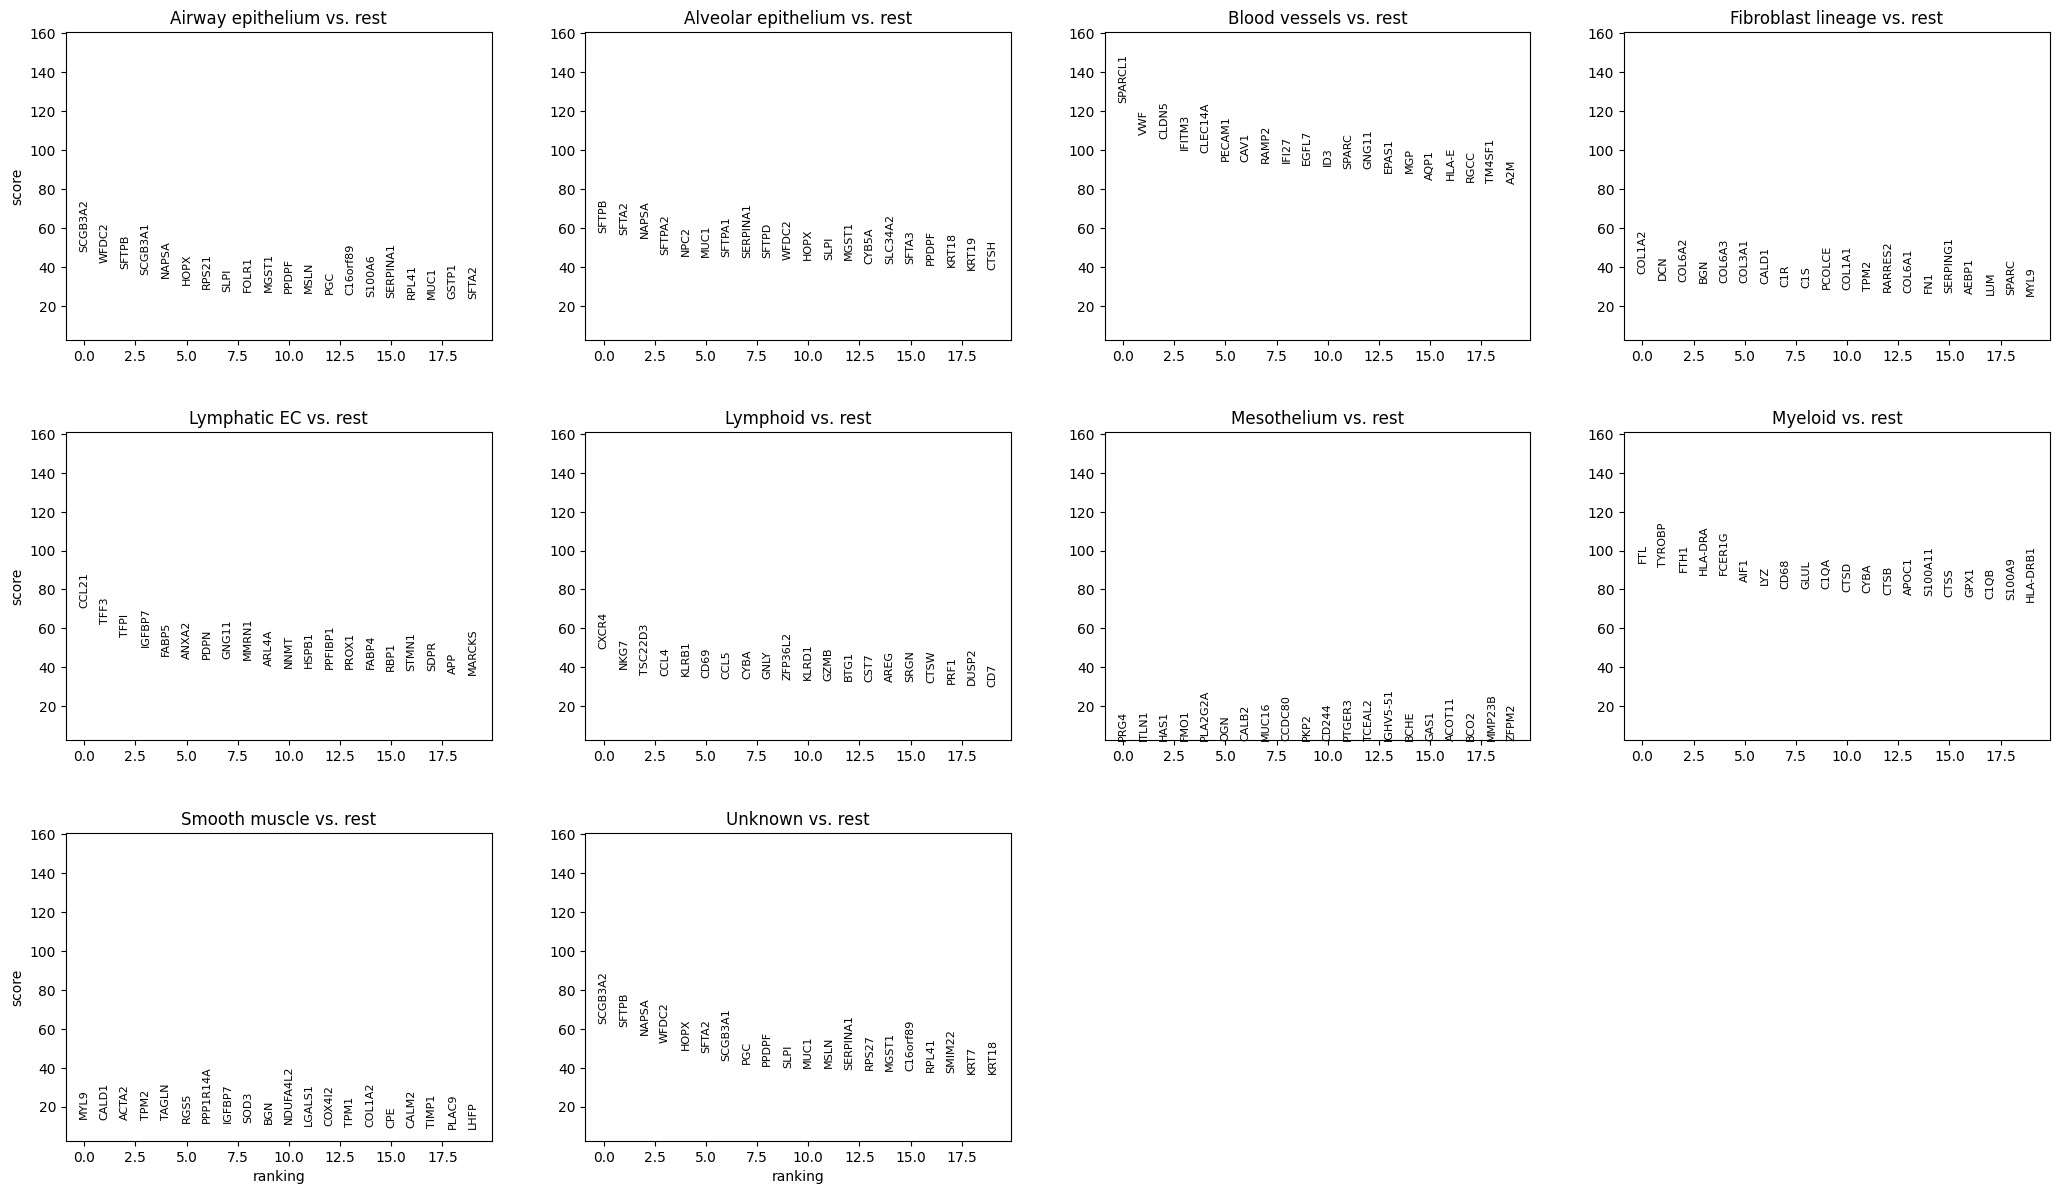

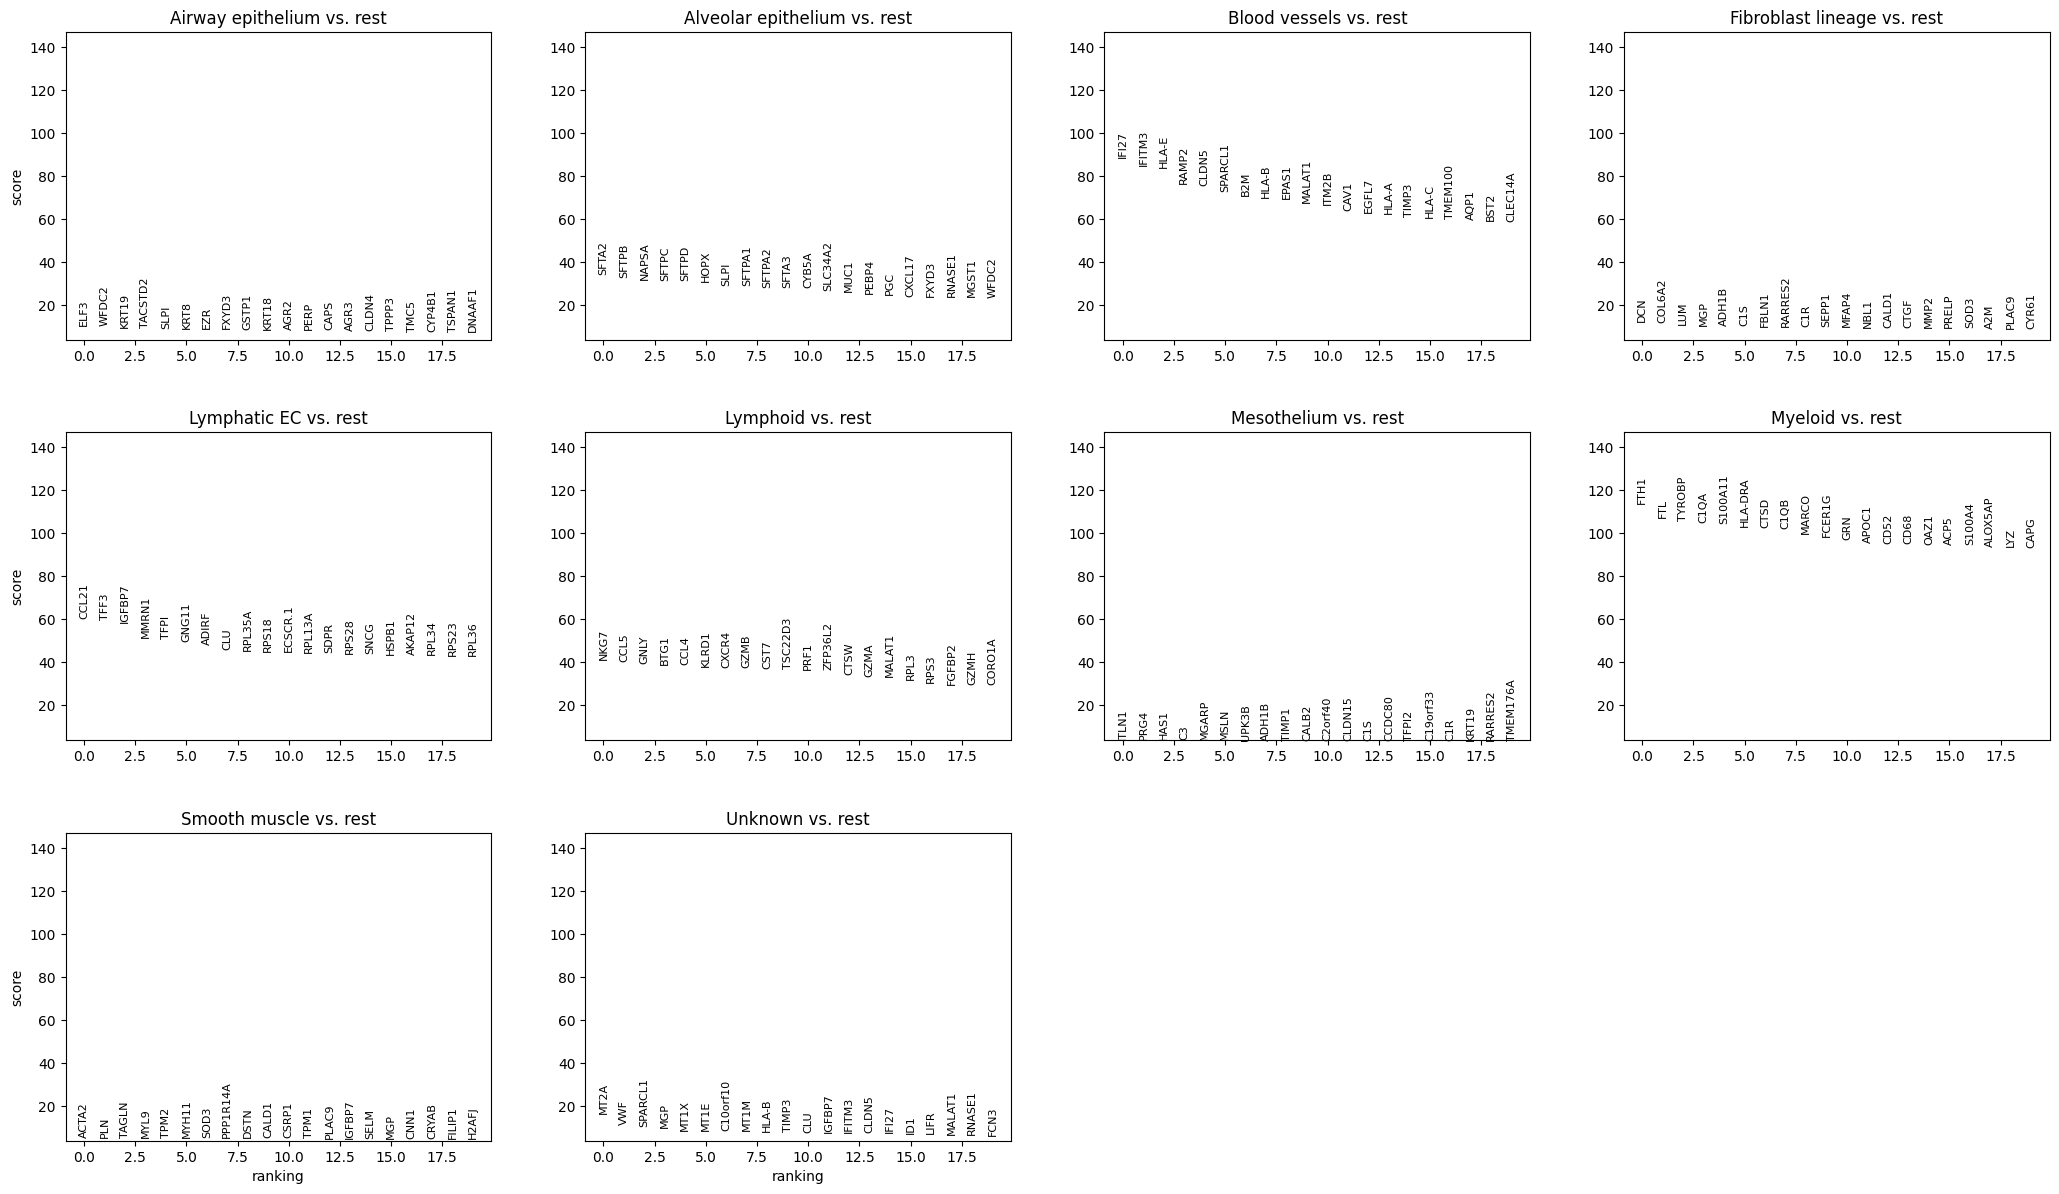

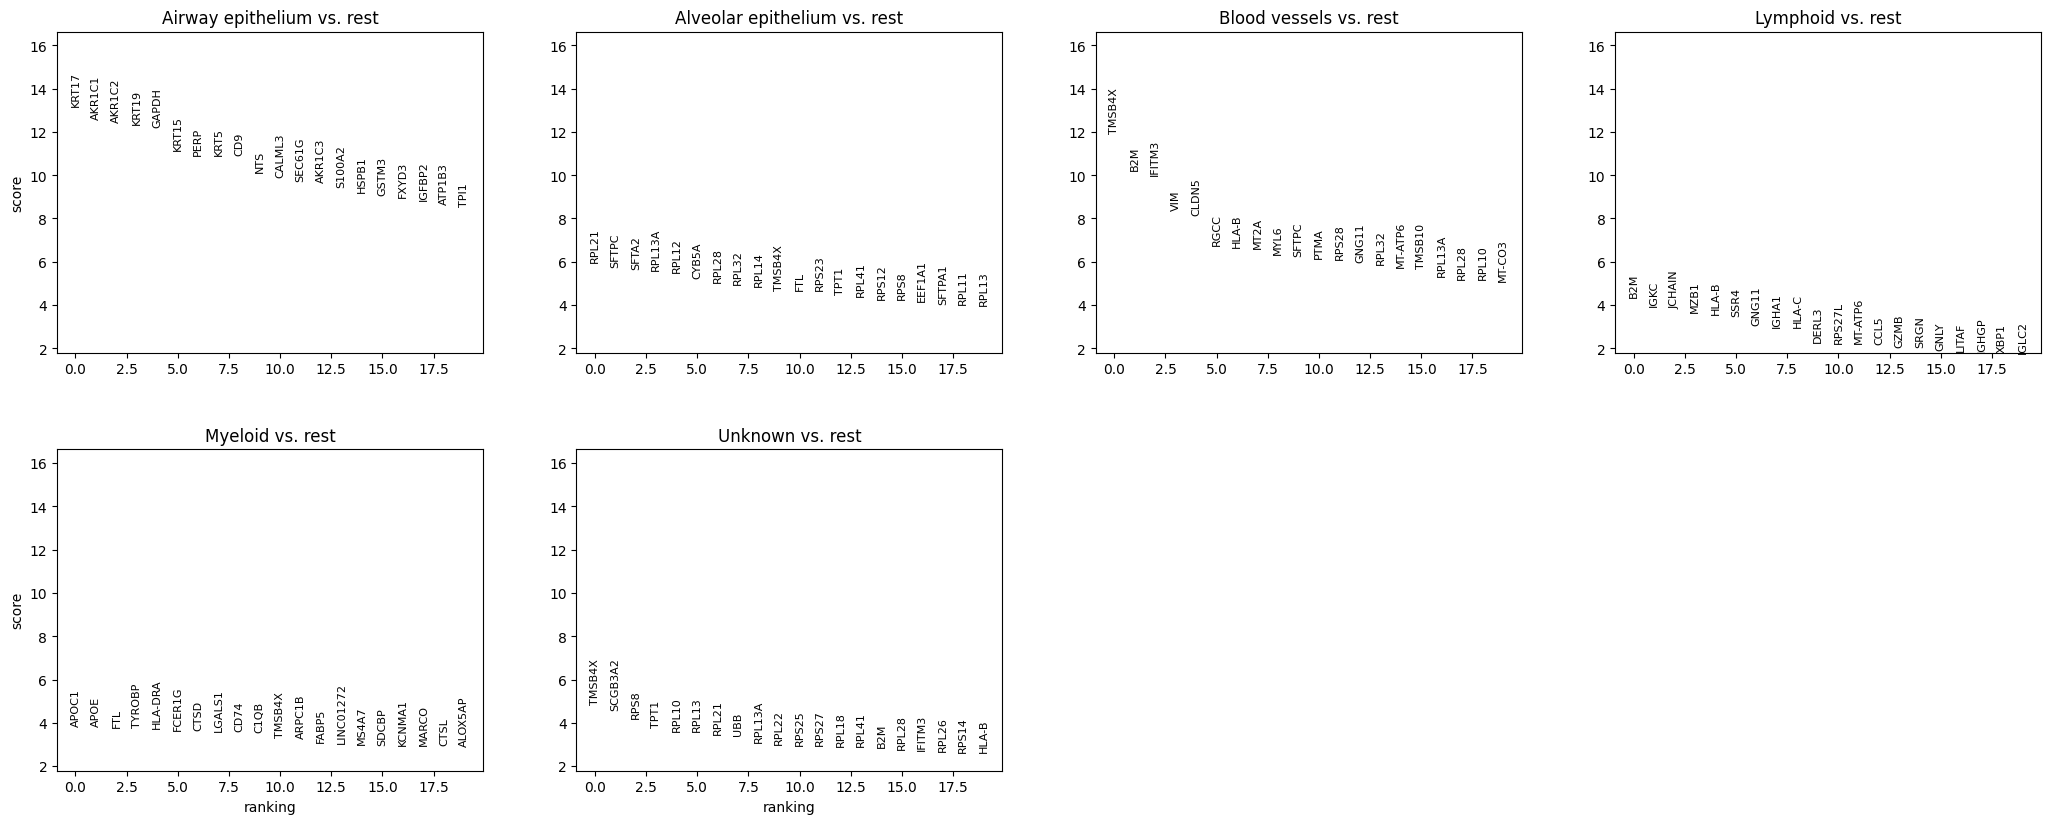

In [107]:
sc.pl.rank_genes_groups(adata_normal_tumor)
sc.pl.rank_genes_groups(adata_normal_normal)
sc.pl.rank_genes_groups(adata_tumor_tumor)

In [118]:
adata_normal_tumor.obs['Level_2_transfered_label'] = adata_normal_tumor.obs['Level_2_transfered_label'].fillna('Unknown')
adata_normal_normal.obs['Level_2_transfered_label'] = adata_normal_normal.obs['Level_2_transfered_label'].fillna('Unknown')
adata_tumor_tumor.obs['Level_2_transfered_label'] = adata_tumor_tumor.obs['Level_2_transfered_label'].fillna('Unknown')

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


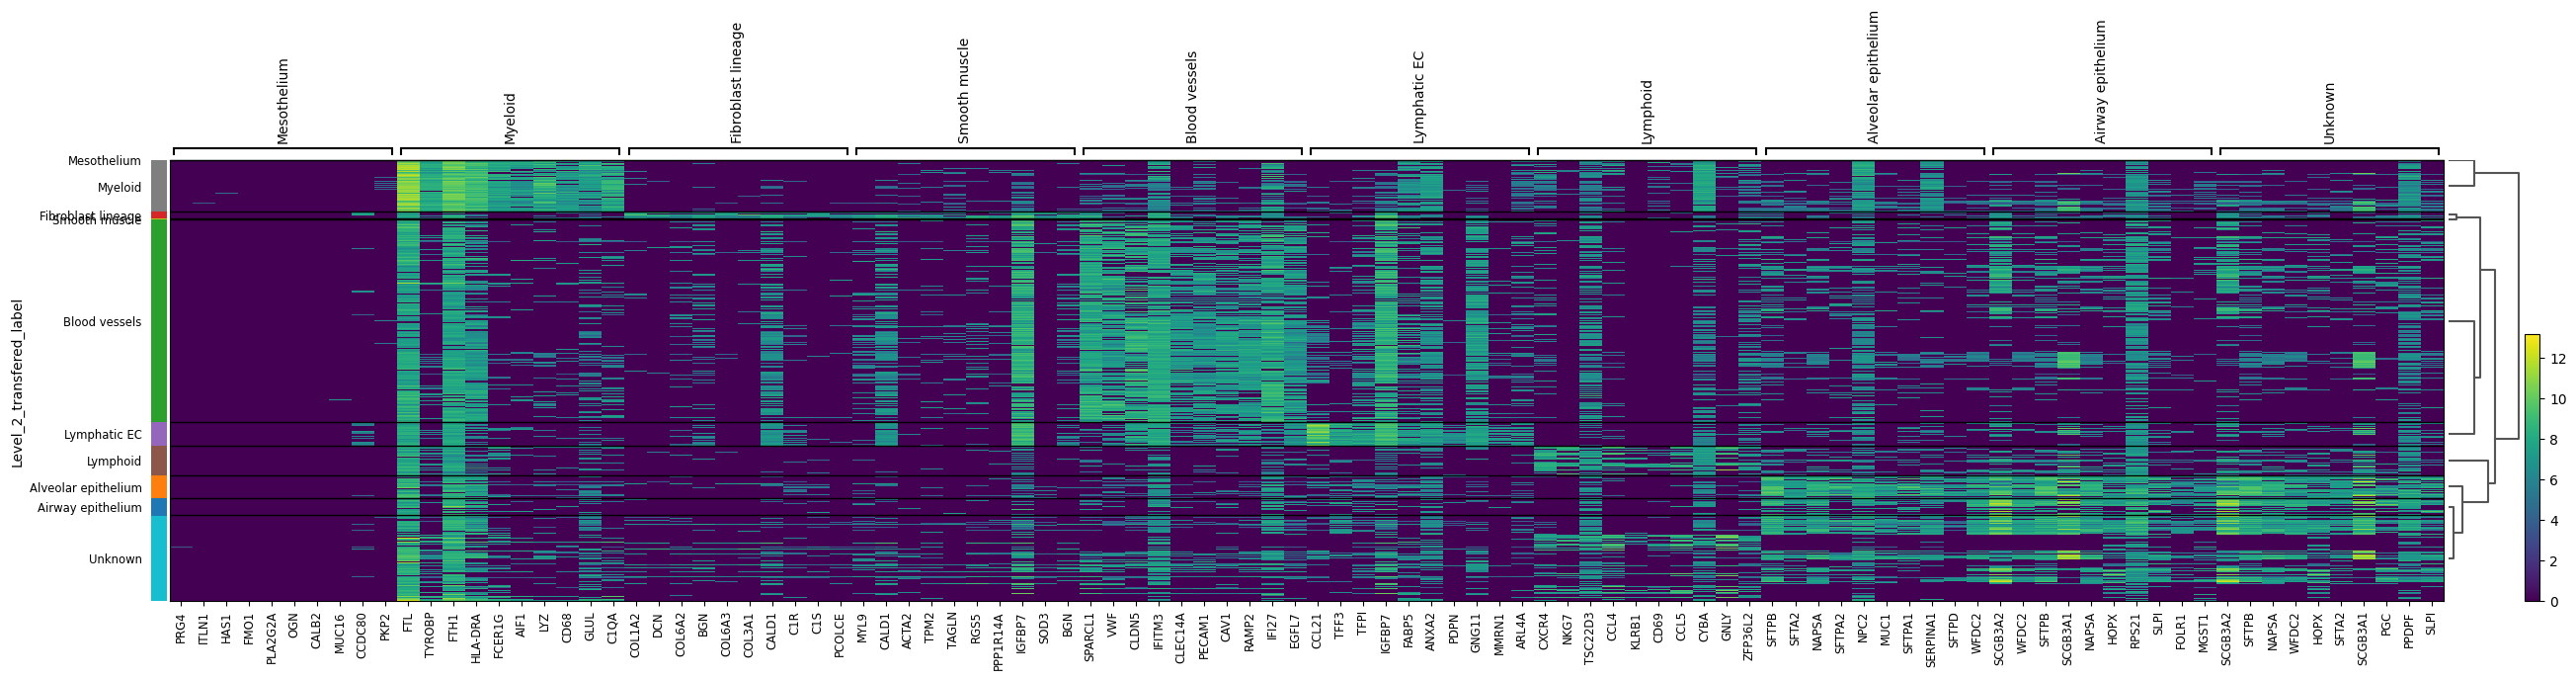

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


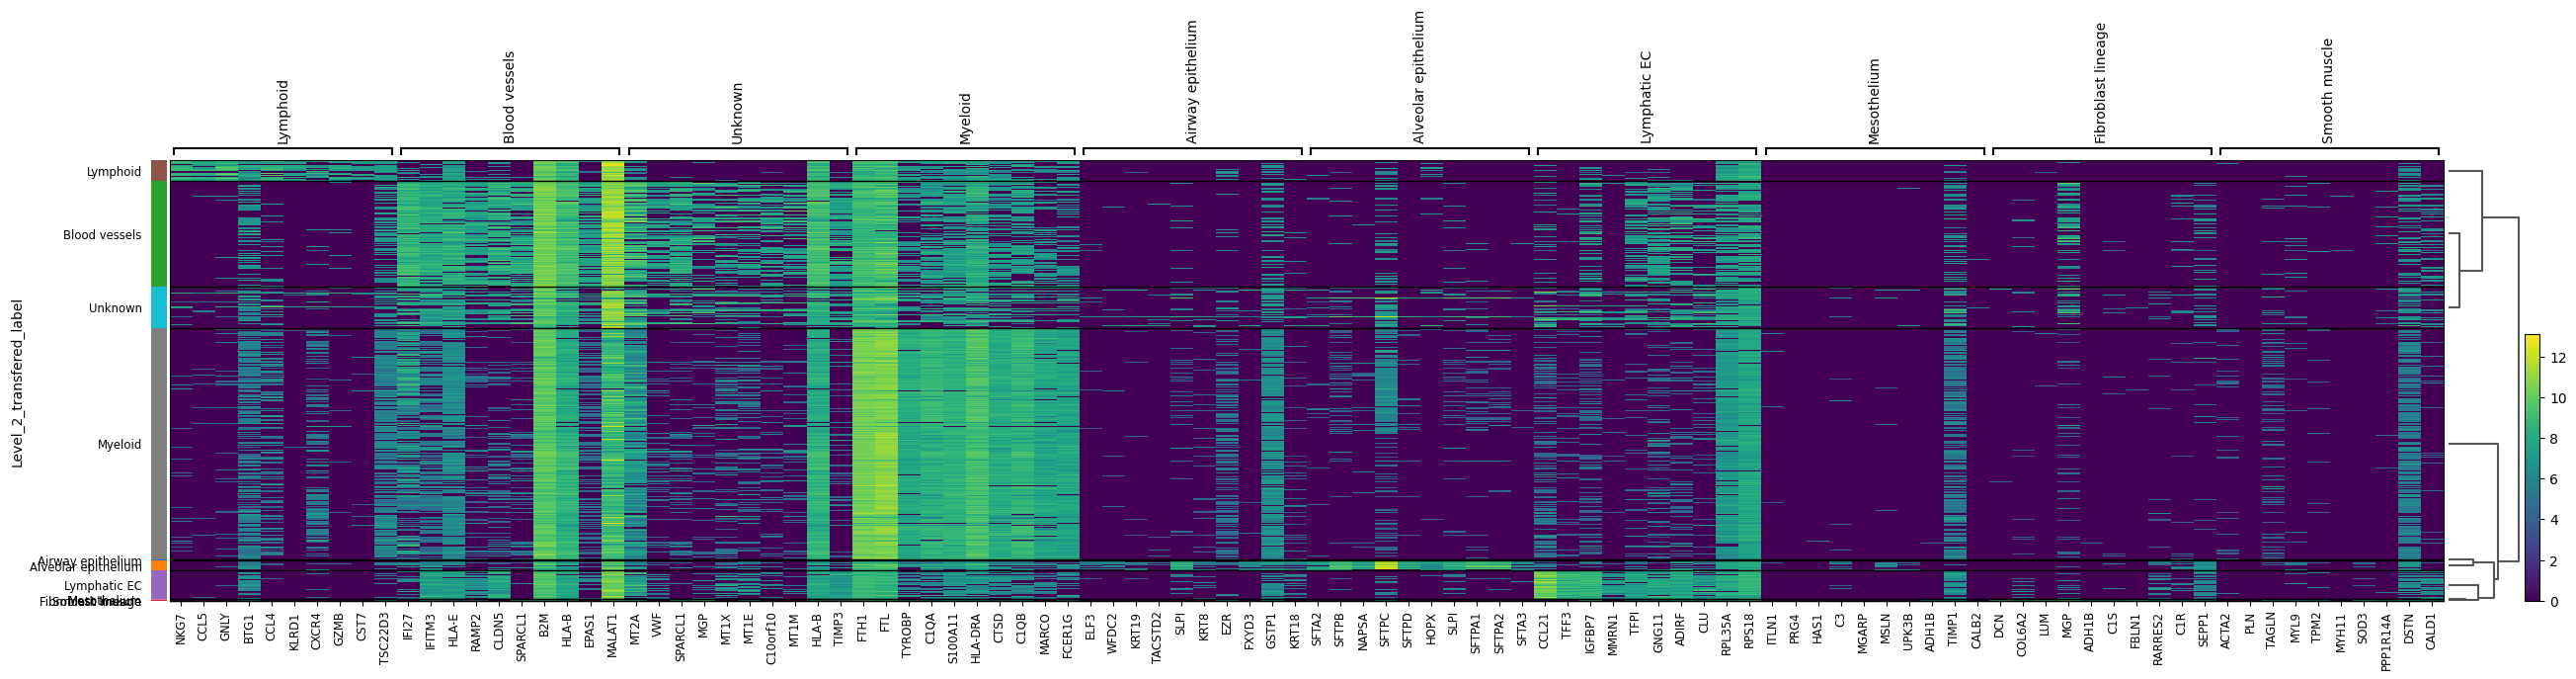

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


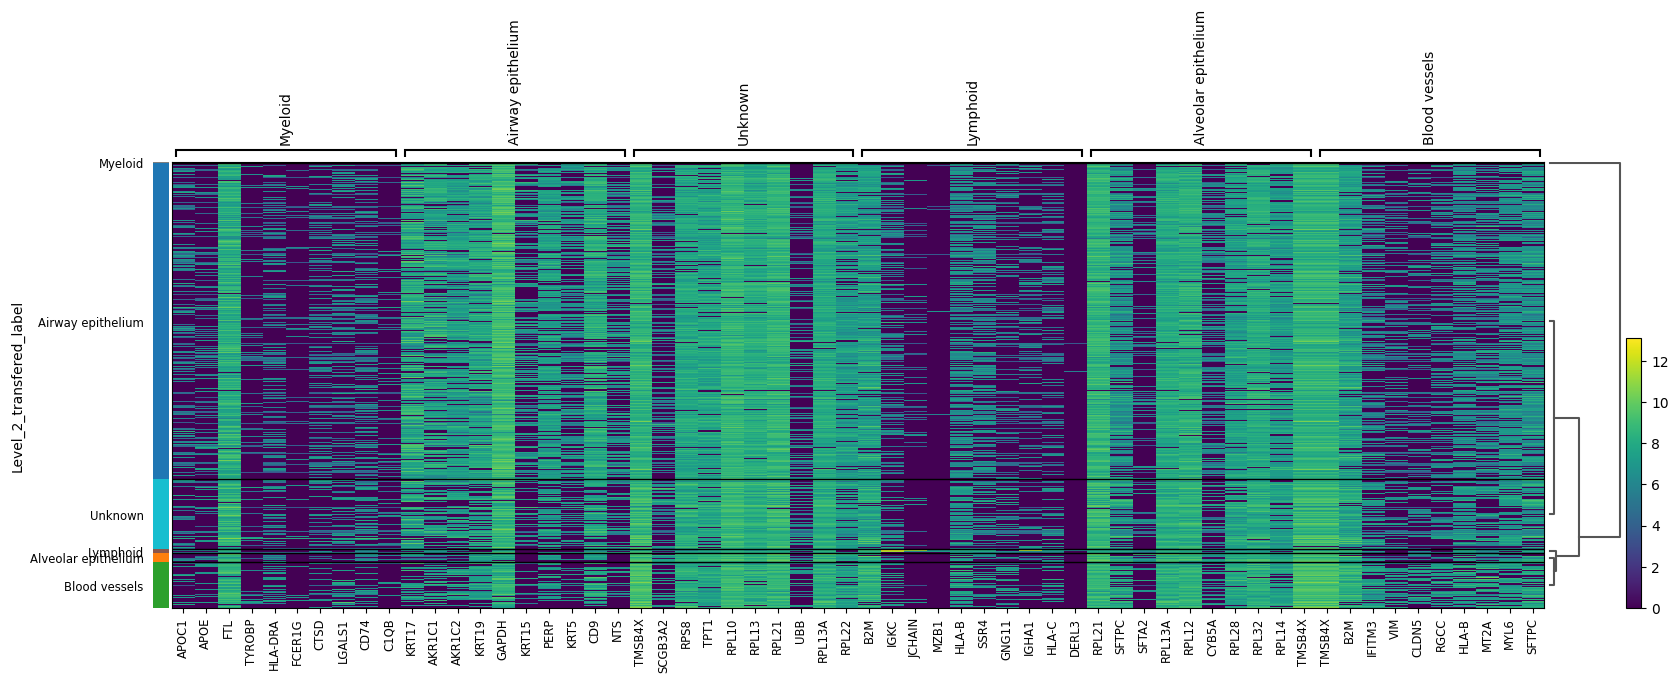

In [121]:
sc.pl.rank_genes_groups_heatmap(adata_normal_tumor, show_gene_labels=True)
sc.pl.rank_genes_groups_heatmap(adata_normal_normal, show_gene_labels=True)
sc.pl.rank_genes_groups_heatmap(adata_tumor_tumor, show_gene_labels=True)

## Plot genes

In [28]:
ens_kd = adata.var.index[adata.var.feature_name == 'KDM6A'][0]
ens_km = adata.var.index[adata.var.feature_name == 'KMT2D'][0]
ens_p53 = adata.var.index[adata.var.feature_name == 'P53'][0]

We do not need to calcualte umap beacuse it already cmoes in `adata`

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


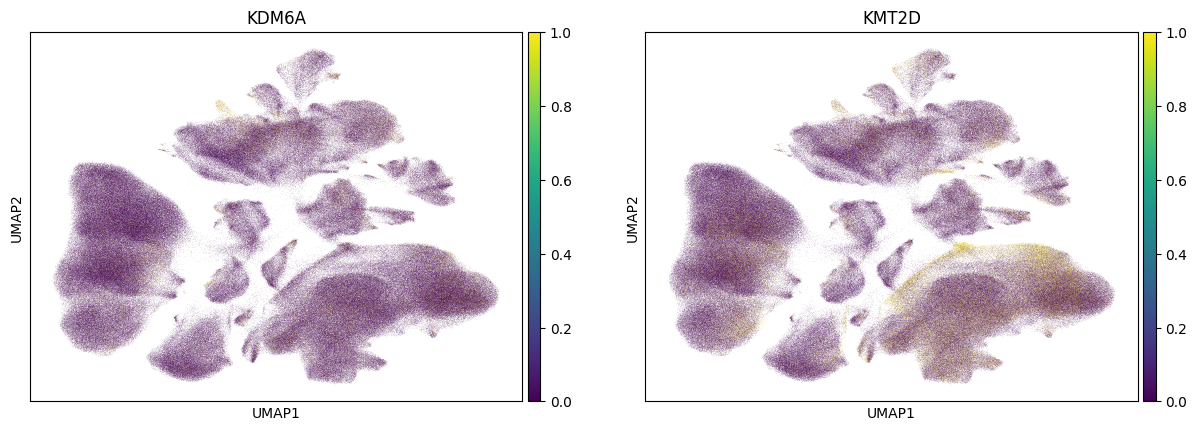

In [70]:
sc.pl.umap(adata, color=[ens_km, ens_kd], vmax = 1, title=['KDM6A', 'KMT2D'])

In [31]:
adata_kd = adata[:,adata.var.index == ens_kd]
adata_km = adata[:,adata.var.index == ens_km]

### Histograms and quantiles

In [43]:
points_kd = adata_kd.X.data
points_km = adata_km.X.data

quant_kd = np.quantile(points_kd, [0.33, 0.66])
quant_km = np.quantile(points_km, [0.33, 0.66])

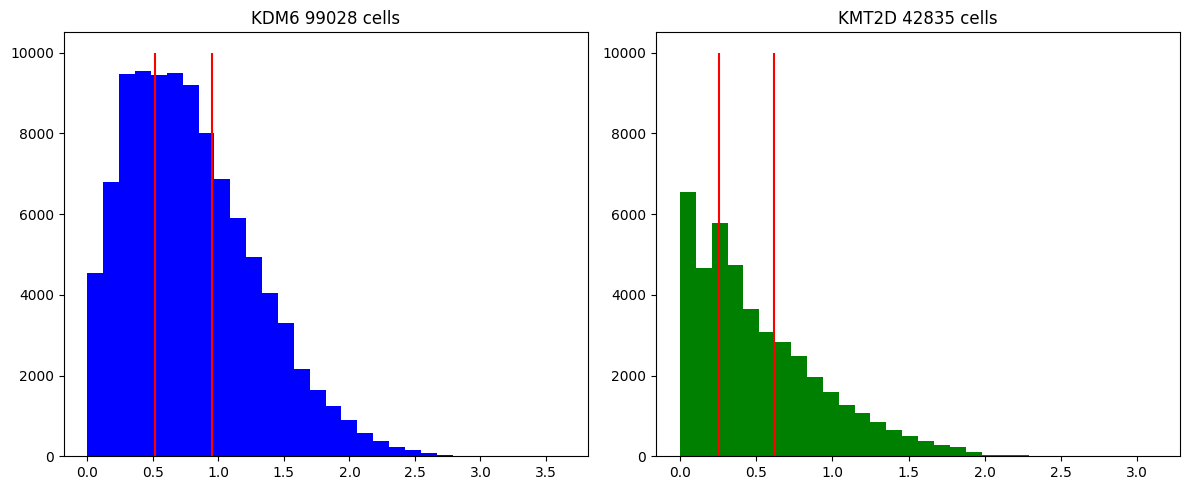

In [102]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 5))

# First histogram
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.hist(points_kd, bins=30, color='blue')
plt.vlines(quant_kd, ymin=0, ymax=10000, colors='red')
plt.title(f'KDM6 {len(points_kd)} cells')
# Second histogram
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.hist(adata_km.X.data, bins=30, color='green')
plt.vlines(quant_km, ymin=0, ymax=10000, colors='red')
plt.title(f'KMT2D {len(points_km)} cells')

# Display the plots
plt.tight_layout()
plt.show()

Check if we have sequenced the genes

In [119]:
adata.var.feature_name[adata.var.feature_name.isin(["P53"])]

Series([], Name: feature_name, dtype: category
Categories (17811, object): ['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', ..., 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1'])

We got this as genes that are involved in the DNA duplication cycle
Get the quantiles and the views neccessary for plotting specfici conditions

In [82]:
compare_genes = ['MCM3', 'NRP1', 'RPA1', 'RFC1','LIG1' ]

levels_quant = ['blue', 'green', 'red']
adata_duplication = adata[:, adata.var.feature_name.isin(duplication_genes)]
tumor_diseases = ['lung adenocarcinoma', 'squamous cell lung carcinoma', 'non-small cell lung carcinoma']

# Add the final value to divide cells into 3 quantiles
quant_kd = np.quantile(points_kd, [0.33, 0.66, 1])
quant_km = np.quantile(points_km, [0.33, 0.66, 1])

In [124]:
adata_tumor = adata[adata.obs.disease.isin(tumor_diseases), :]
adata_normal = adata[adata.obs.disease.isin('normal'), :]

adata_kd_tumor = adata_tumor[:, adata_tumor.var.index == ens_genes[0]]
adata_kd_normal = adata_normal[:, adata_normla.var.index == ens_genes[0]]

adata_km_tumor = adata_tumor[:, adata_tumor.var.index == ens_genes[1]]
adata_km_normal = adata_normal[:, adata_normal.var.index == ens_genes[1]]

TypeError: only list-like objects are allowed to be passed to isin(), you passed a `str`

### Function for hist grid

In [115]:
from typing import List

def plot_hist_grid(adata: ad.AnnData, compare_genes: List[str], ens_genes: List[str],
                   adata_kd: ad.AnnData = None, adata_km: ad.AnnData = None,
                   adata_compare: ad.AnnData = None,
                   quant_km: List[float] = None, quant_kd: List[float] = None,
                   colors_quant: List[str]=['blue', 'green', 'red'],
                   legend_loc: str = 'upper right'):

    name_genes = [adata.var.feature_name[adata.var.index == ens][0] for ens in ens_genes]

    if not adata_compare:
        adata_compare = adata[:, adata.var.feature_name.isin(compare_genes)]
    if not adata_kd:
        adata_kd = adata[:,adata.var.index == ens_genes[0]]
    if not adata_km:
        adata_km = adata[:,adata.var.index == ens_km[1]]

    
    if not quant_kd:
        points_kd = adata_kd.X.data
        quant_kd = np.quantile(points_kd, [0.33, 0.66, 1])

    if not quant_km:
        points_km = adata_km.X.data
        quant_km = np.quantile(points_km, [0.33, 0.66, 1])        
    
    color_labels = ['Low', 'Middle', 'High']  # Adjust these labels as necessary
    levels_quant = ['blue', 'green', 'red']
    colors = levels_quant

    # Create a list of patch handles for these colors
    handles = [mpatches.Patch(color=color, label=label) for label, color in zip(color_labels, colors)]

    n_genes = len(compare_genes)
    plt.figure(figsize=(3*(n_genes+1), 15))

    for i, quant in enumerate(quant_kd):
        quant_ = 0 if i == 0 else quant_kd[i-1]
        # We use multiply because sparse matrices
        condition_kd = (adata_kd.X < quant).multiply(adata_kd.X > quant_)
        condition_km = (adata_km.X < quant).multiply(adata_km.X > quant_)
        adata_quant = adata_compare[condition_kd.multiply(condition_km), : ]
    
        for j, gene in enumerate(compare_genes):
            print(gene)
            adata_gene = adata_quant[:, adata_quant.var.feature_name == gene]
            plt.subplot(3, n_genes, i*len(compare_genes) + j+1) # 3 rows, n columns ith plot
            plt.hist(adata_gene.X.data, bins=20, color=levels_quant[i])
            plt.title(gene)
    
    # Add an overall title
    title: str = f'Hists for genes in different {name_genes[0]} & {name_genes[1]} expression levels',
    plt.suptitle(title)
    
    # Create a single legend for the figure
    plt.figlegend(handles=handles, loc=legend_loc, ncol=len(color_labels))
    plt.show()

### KMT2D & KDM6A

#### Normal & Tumor

/usr/local/lib/python3.11/site-packages/scipy/sparse/_compressed.py:290: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1


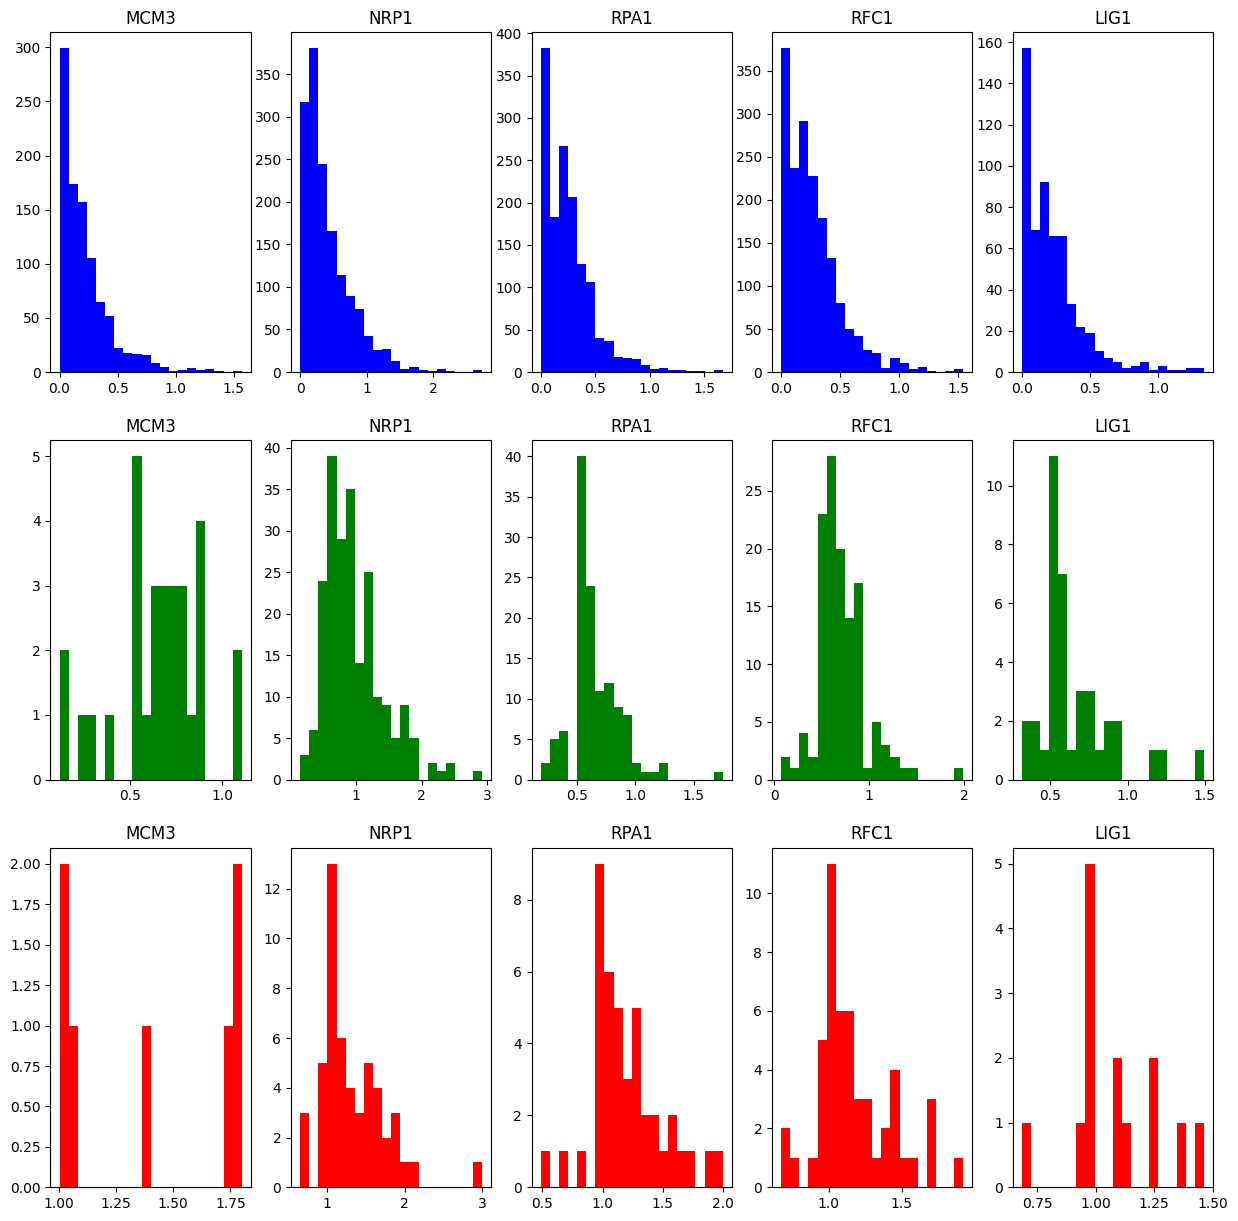

In [170]:
plt.figure(figsize=(15, 15))

for i, quant in enumerate(quant_kd):
    quant_ = 0 if i == 0 else quant_kd[i-1]
    # We use multiply because sparse matrices
    condition_kd = (adata_kd.X < quant).multiply(adata_kd.X > quant_)
    condition_km = (adata_km.X < quant).multiply(adata_km.X > quant_)
    adata_quant = adata_duplication[condition_kd.multiply(condition_km), : ]

    for j, gene in enumerate(duplication_genes):
        print(gene)
        adata_gene = adata_quant[:, adata_quant.var.feature_name == gene]
        plt.subplot(3, 5, i*len(duplication_genes) + j+1) # 3 rows, 5 columns ith plot
        plt.hist(adata_gene.X.data, bins=20, color=levels_quant[i])
        plt.title(gene)

plt.show()

#### Tumor

/tmp/ipykernel_72651/114102669.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name_genes = [adata.var.feature_name[adata.var.index == ens][0] for ens in ens_genes]
/usr/local/lib/python3.11/site-packages/scipy/sparse/_compressed.py:290: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


CASP3
CASP7
PARP1
BAX
CASP3
CASP7
PARP1
BAX
CASP3
CASP7
PARP1
BAX


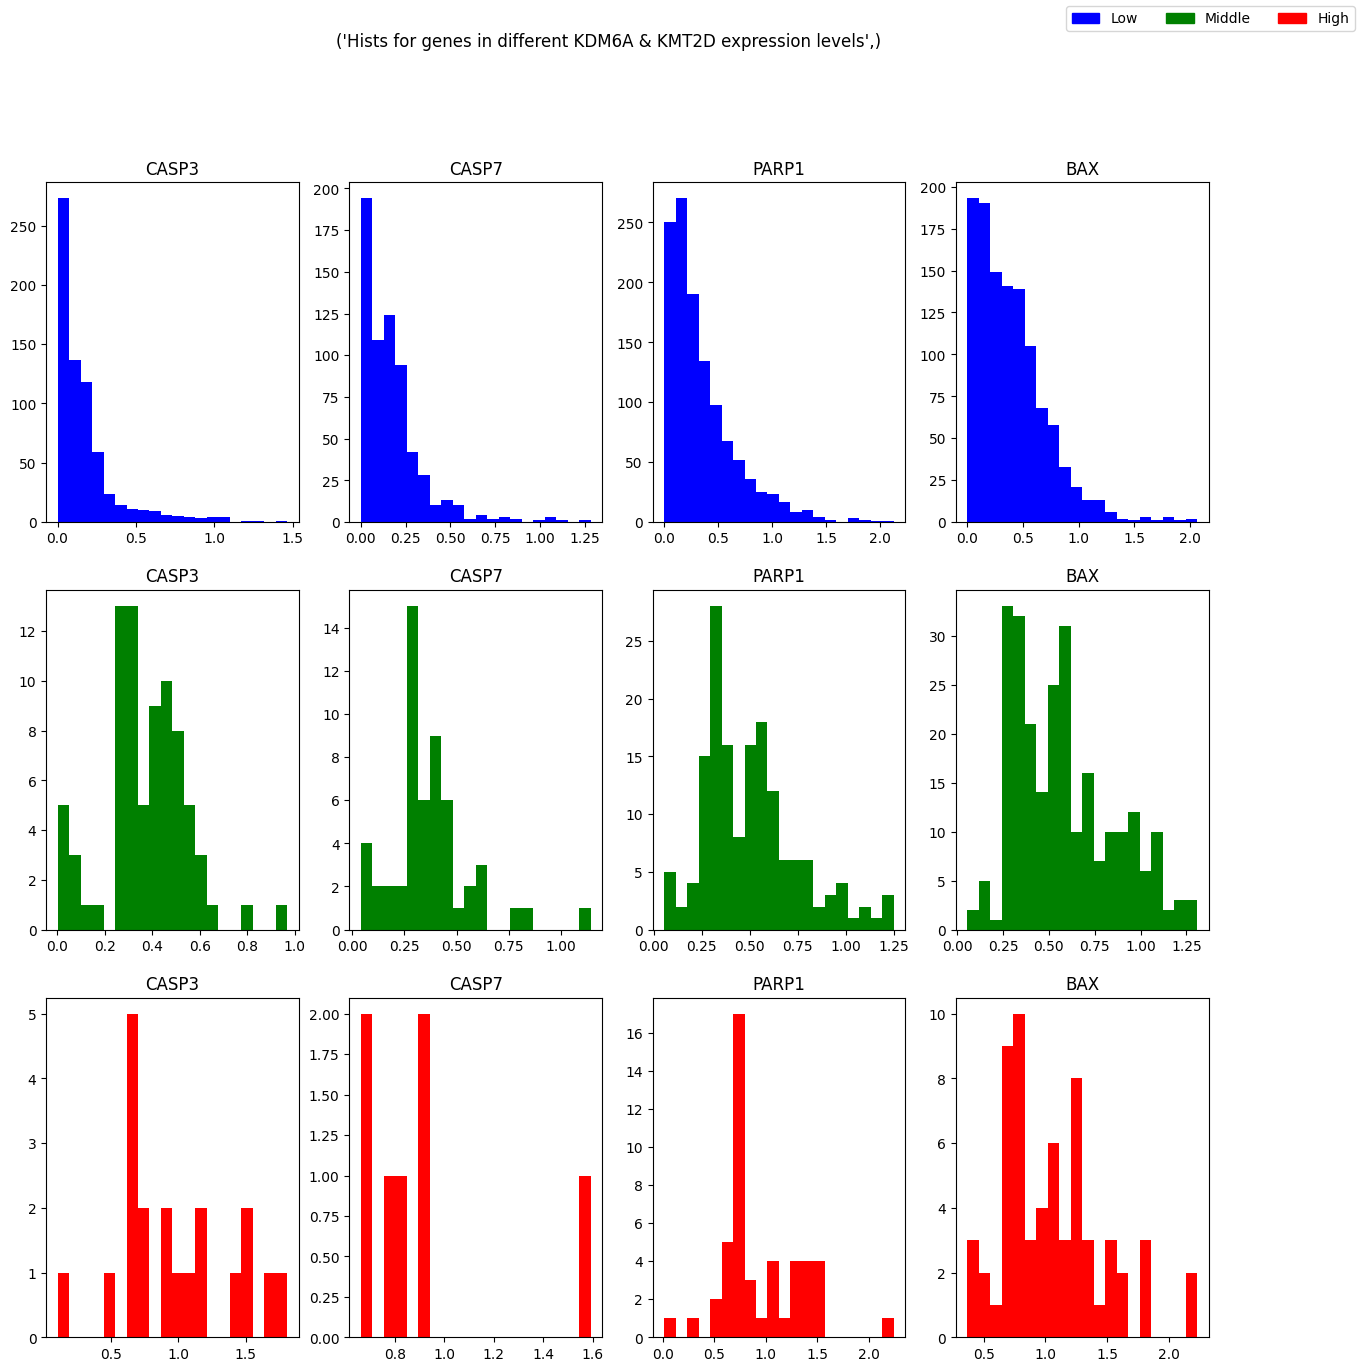

In [105]:
plot_hist_grid(adata_tumor, ['CASP3', 'CASP7', 'PARP1', 'BAX'],
               [ens_kd, ens_km], adata_kd_tumor, adata_km_tumor)

/tmp/ipykernel_72651/114102669.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name_genes = [adata.var.feature_name[adata.var.index == ens][0] for ens in ens_genes]
/usr/local/lib/python3.11/site-packages/scipy/sparse/_compressed.py:290: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


BAK1
BID
BBC3
PMAIP1
BAK1
BID
BBC3
PMAIP1
BAK1
BID
BBC3
PMAIP1


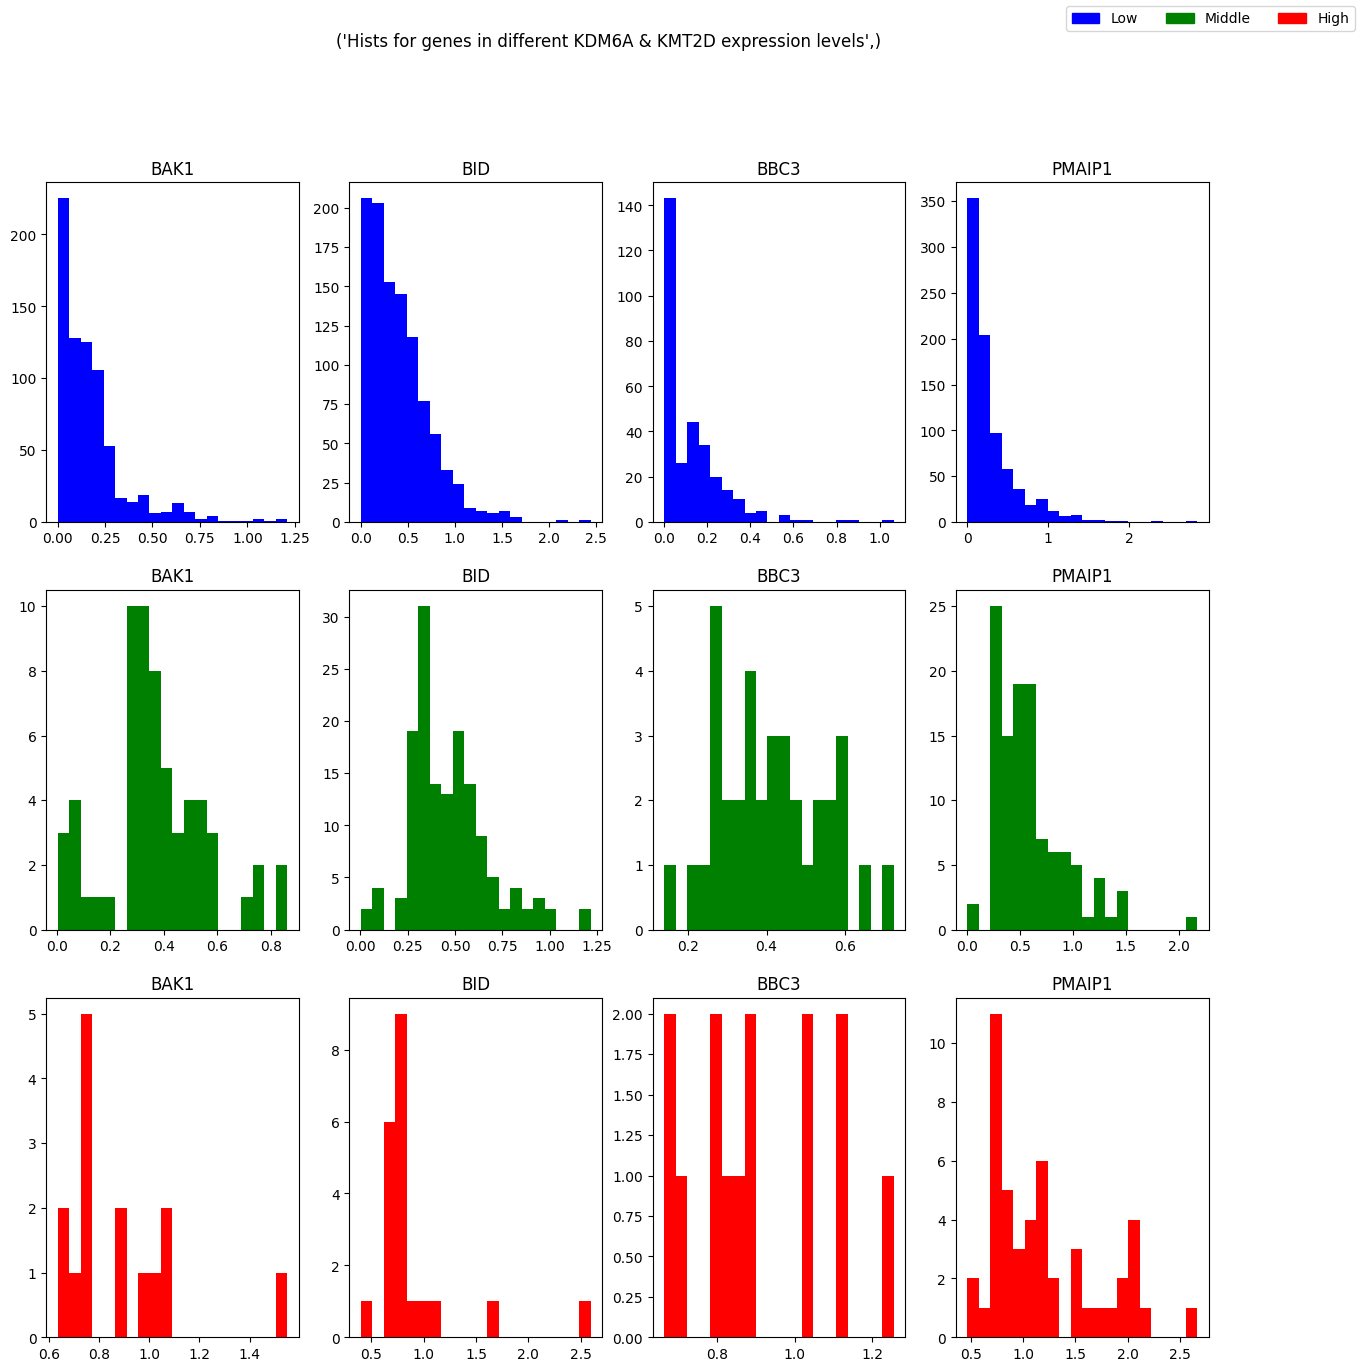

In [121]:
plot_hist_grid(adata_tumor, ['BAK1', 'BID', 'BBC3', 'PMAIP1'],
               [ens_kd, ens_km], adata_kd_tumor, adata_km_tumor)

/tmp/ipykernel_72651/114102669.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name_genes = [adata.var.feature_name[adata.var.index == ens][0] for ens in ens_genes]
/usr/local/lib/python3.11/site-packages/scipy/sparse/_compressed.py:290: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


BCL2
BCL2L1
MCL1
TP53
BCL2
BCL2L1
MCL1
TP53
BCL2
BCL2L1
MCL1
TP53


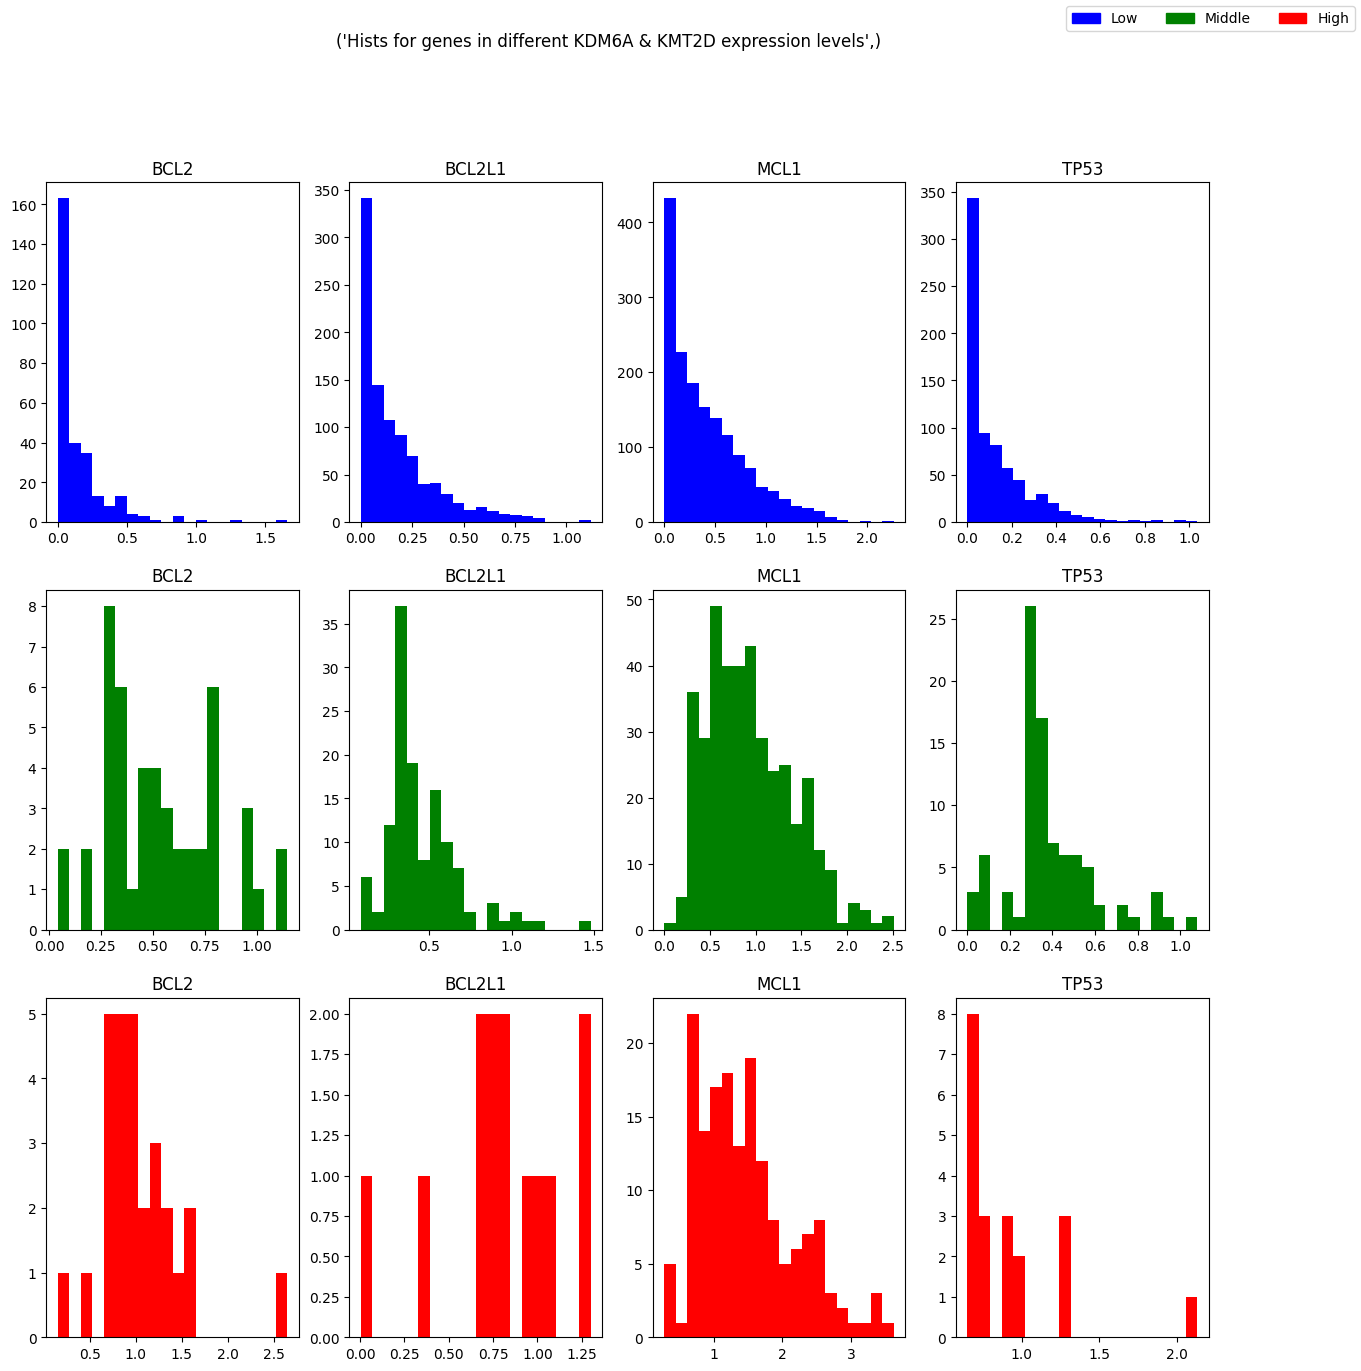

In [120]:
plot_hist_grid(adata_tumor, ['BCL2', 'BCL2L1', 'MCL1', 'TP53'],
               [ens_kd, ens_km], adata_kd_tumor, adata_km_tumor)

#### Normal

/tmp/ipykernel_72651/114102669.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name_genes = [adata.var.feature_name[adata.var.index == ens][0] for ens in ens_genes]
/usr/local/lib/python3.11/site-packages/scipy/sparse/_compressed.py:290: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


CASP3
CASP7
PARP1
BAX
CASP3
CASP7
PARP1
BAX
CASP3
CASP7
PARP1
BAX


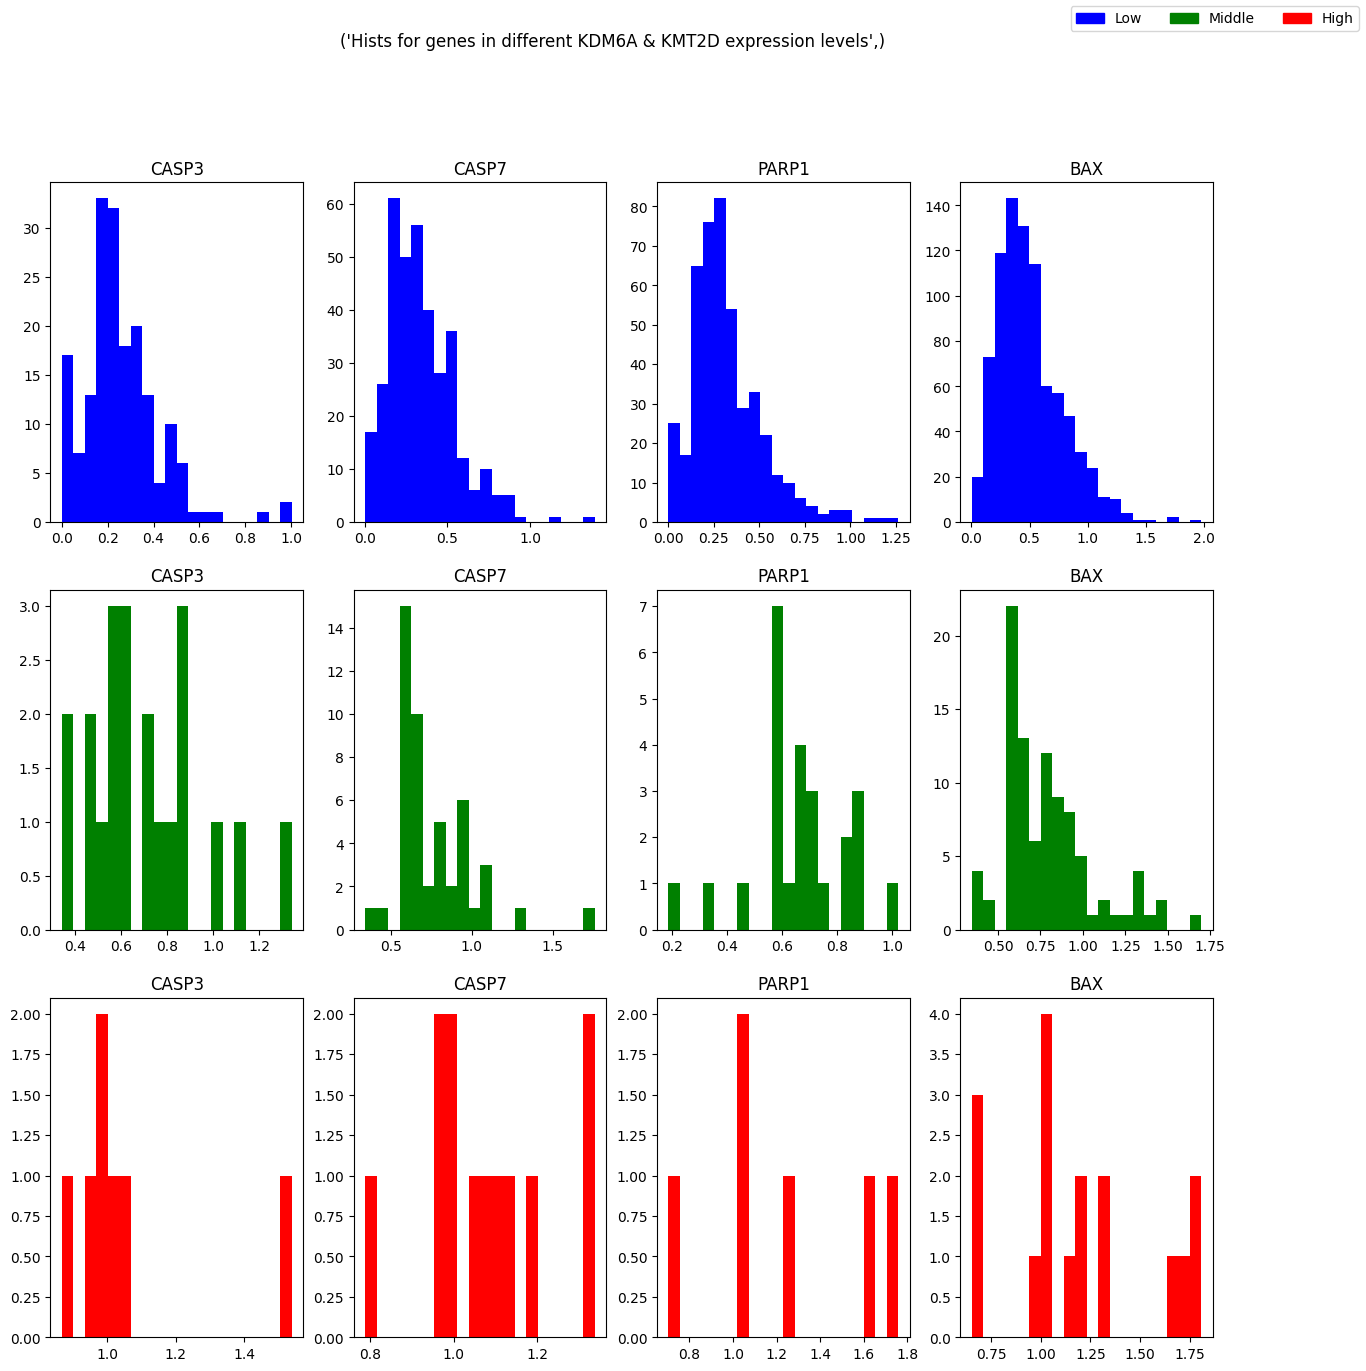

In [116]:
plot_hist_grid(adata_normal, ['CASP3', 'CASP7', 'PARP1', 'BAX'],
               [ens_kd, ens_km], adata_kd_normal, adata_km_normal)

/tmp/ipykernel_72651/114102669.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name_genes = [adata.var.feature_name[adata.var.index == ens][0] for ens in ens_genes]
/usr/local/lib/python3.11/site-packages/scipy/sparse/_compressed.py:290: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


BAK1
BID
BBC3
PMAIP1
BAK1
BID
BBC3
PMAIP1
BAK1
BID
BBC3
PMAIP1


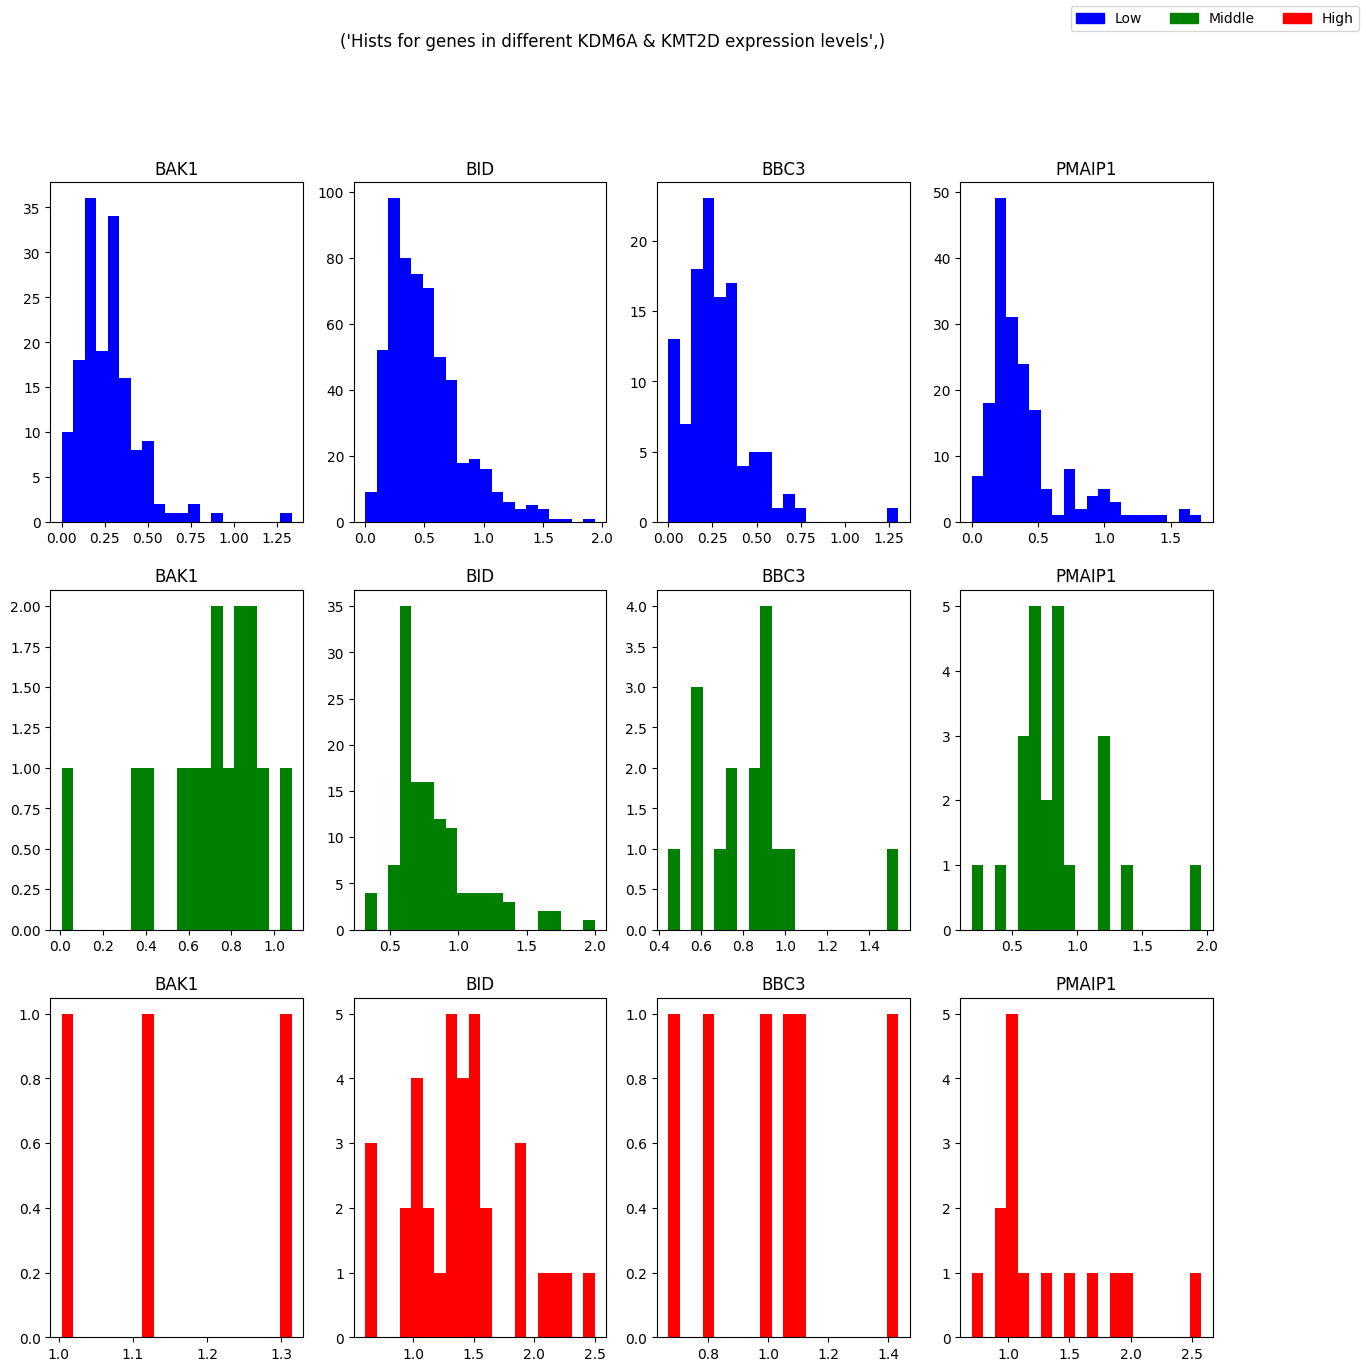

In [123]:
plot_hist_grid(adata_normal, ['BAK1', 'BID', 'BBC3', 'PMAIP1'],
               [ens_kd, ens_km], adata_kd_normal, adata_km_normal)

/tmp/ipykernel_72651/114102669.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name_genes = [adata.var.feature_name[adata.var.index == ens][0] for ens in ens_genes]
/usr/local/lib/python3.11/site-packages/scipy/sparse/_compressed.py:290: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


BCL2
BCL2L1
MCL1
TP53
BCL2
BCL2L1
MCL1
TP53
BCL2
BCL2L1
MCL1
TP53


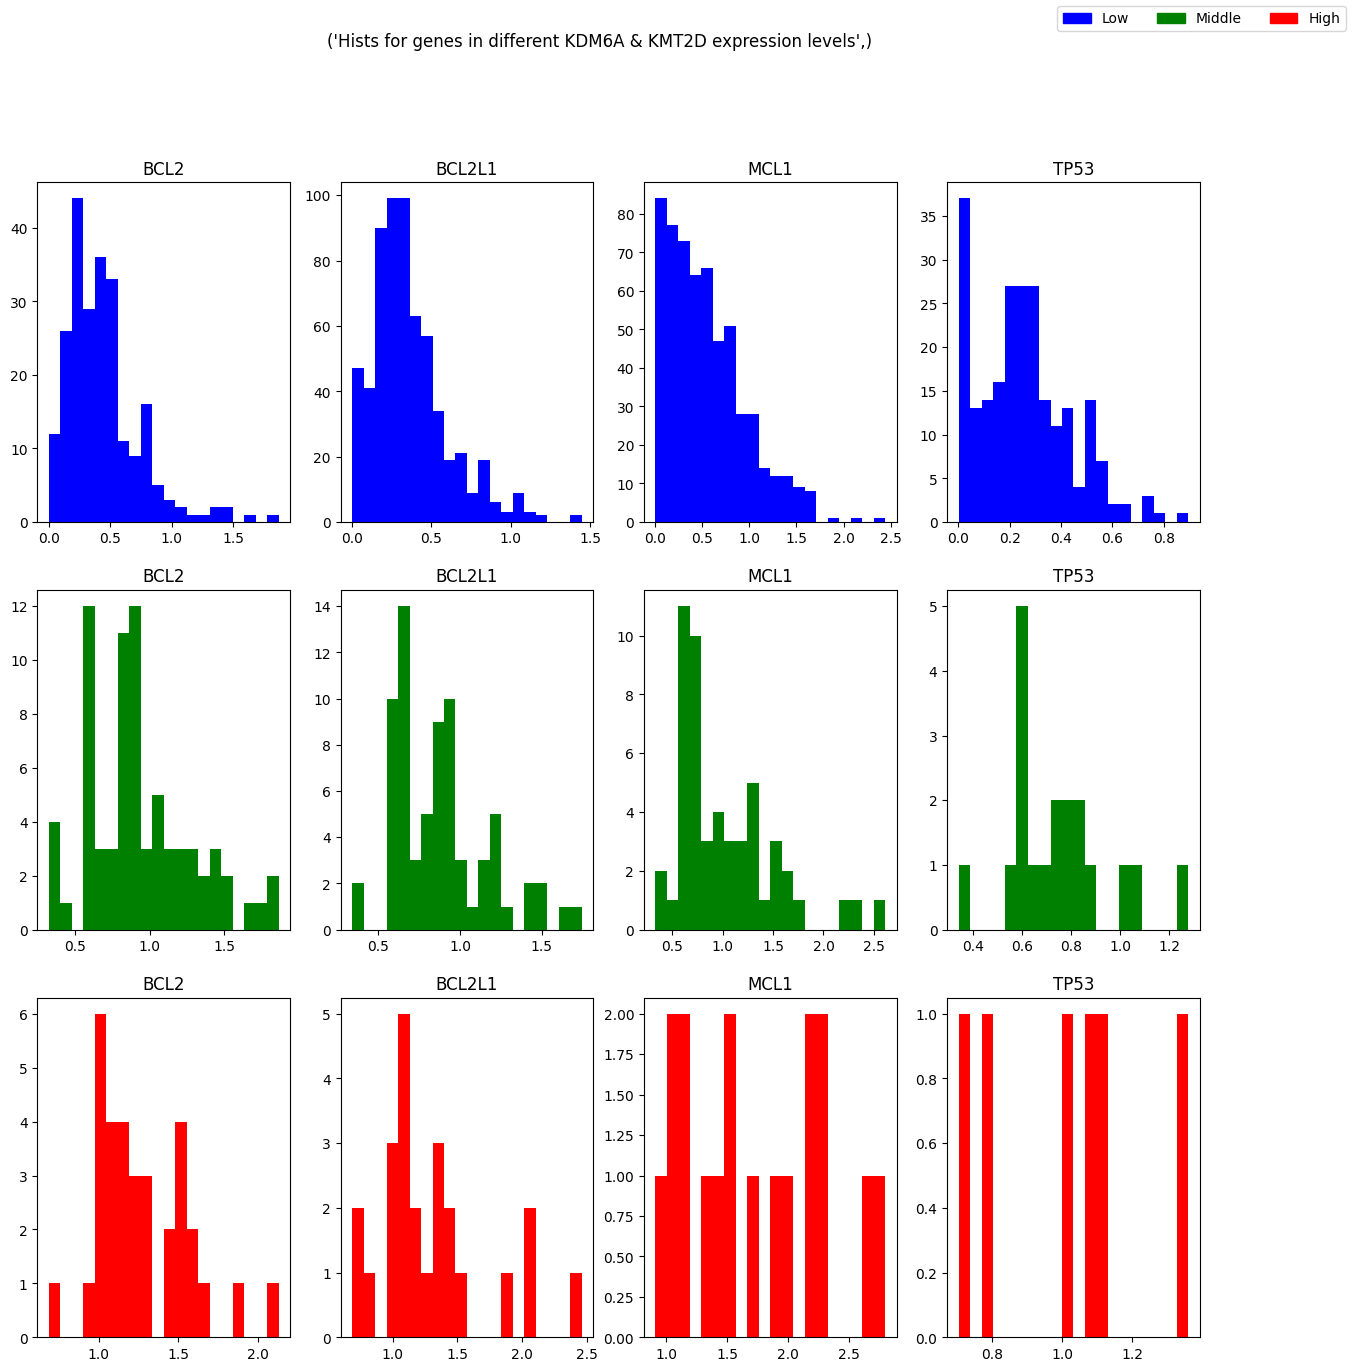

In [122]:
plot_hist_grid(adata_normal, ['BCL2', 'BCL2L1', 'MCL1', 'TP53'],
               [ens_kd, ens_km], adata_kd_normal, adata_km_normal)

### KMT2D

MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1


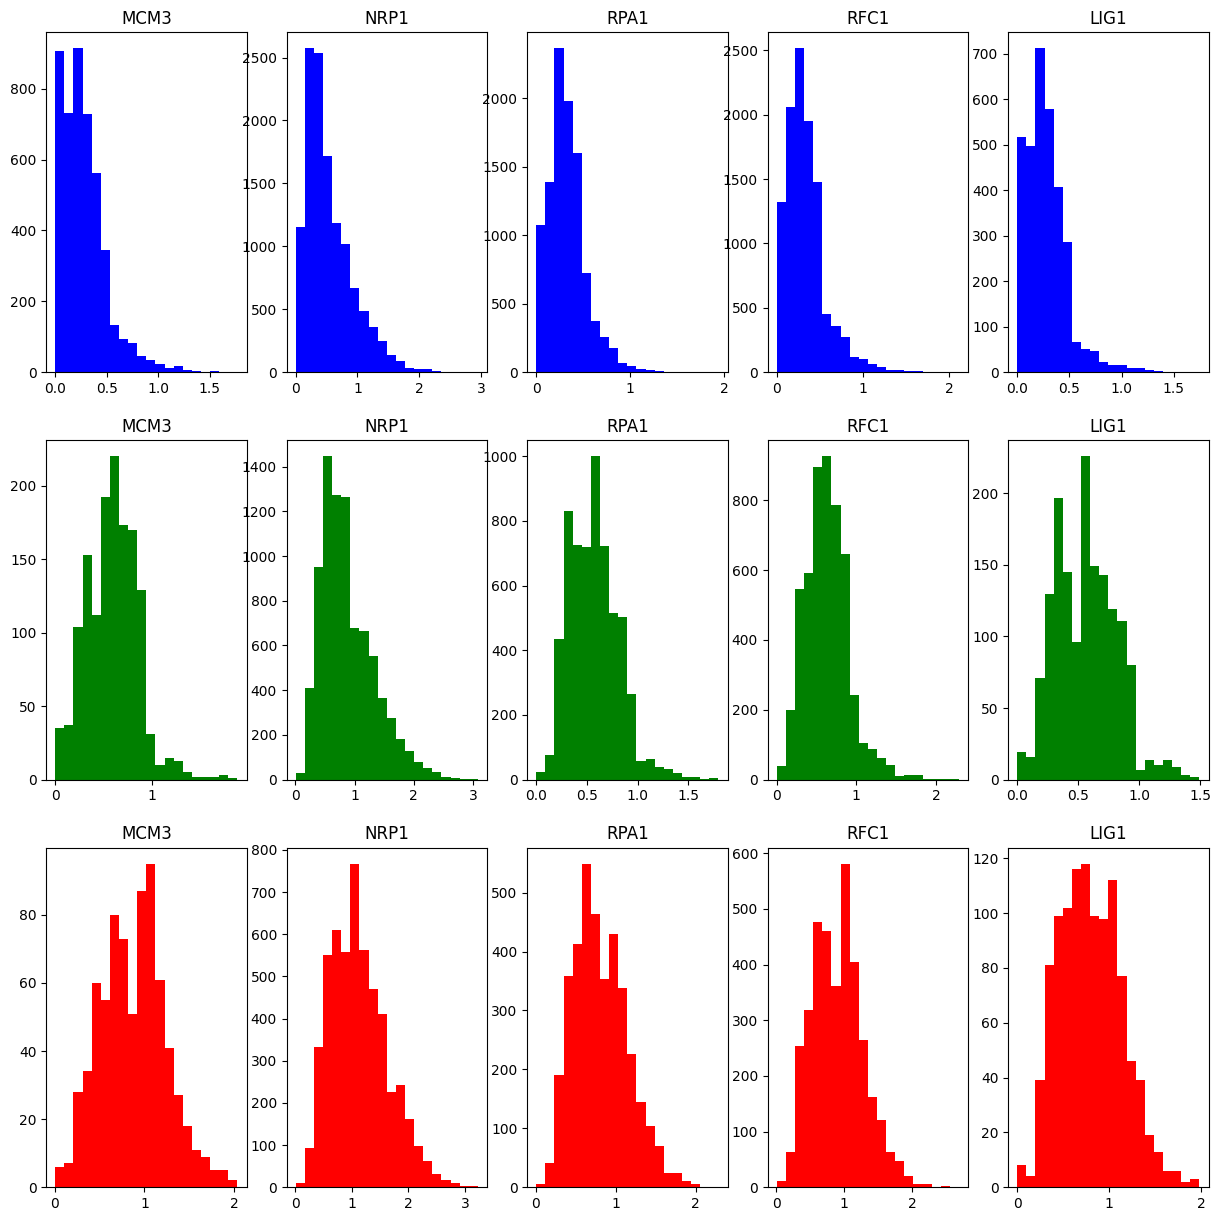

In [168]:
plt.figure(figsize=(15, 15))

for i, quant in enumerate(quant_kd):
    quant_ = 0 if i == 0 else quant_kd[i-1]
    # We use multiply because sparse matrices
    adata_quant = adata_duplication[(adata_kd.X < quant).multiply(adata_kd.X > quant_), : ]

    for j, gene in enumerate(duplication_genes):
        print(gene)
        adata_gene = adata_quant[:, adata_quant.var.feature_name == gene]
        plt.subplot(3, 5, i*len(duplication_genes) + j+1) # 3 rows, 5 columns ith plot
        plt.hist(adata_gene.X.data, bins=20, color=levels_quant[i])
        plt.title(gene)

plt.show()

### KMD6A

MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1
MCM3
NRP1
RPA1
RFC1
LIG1


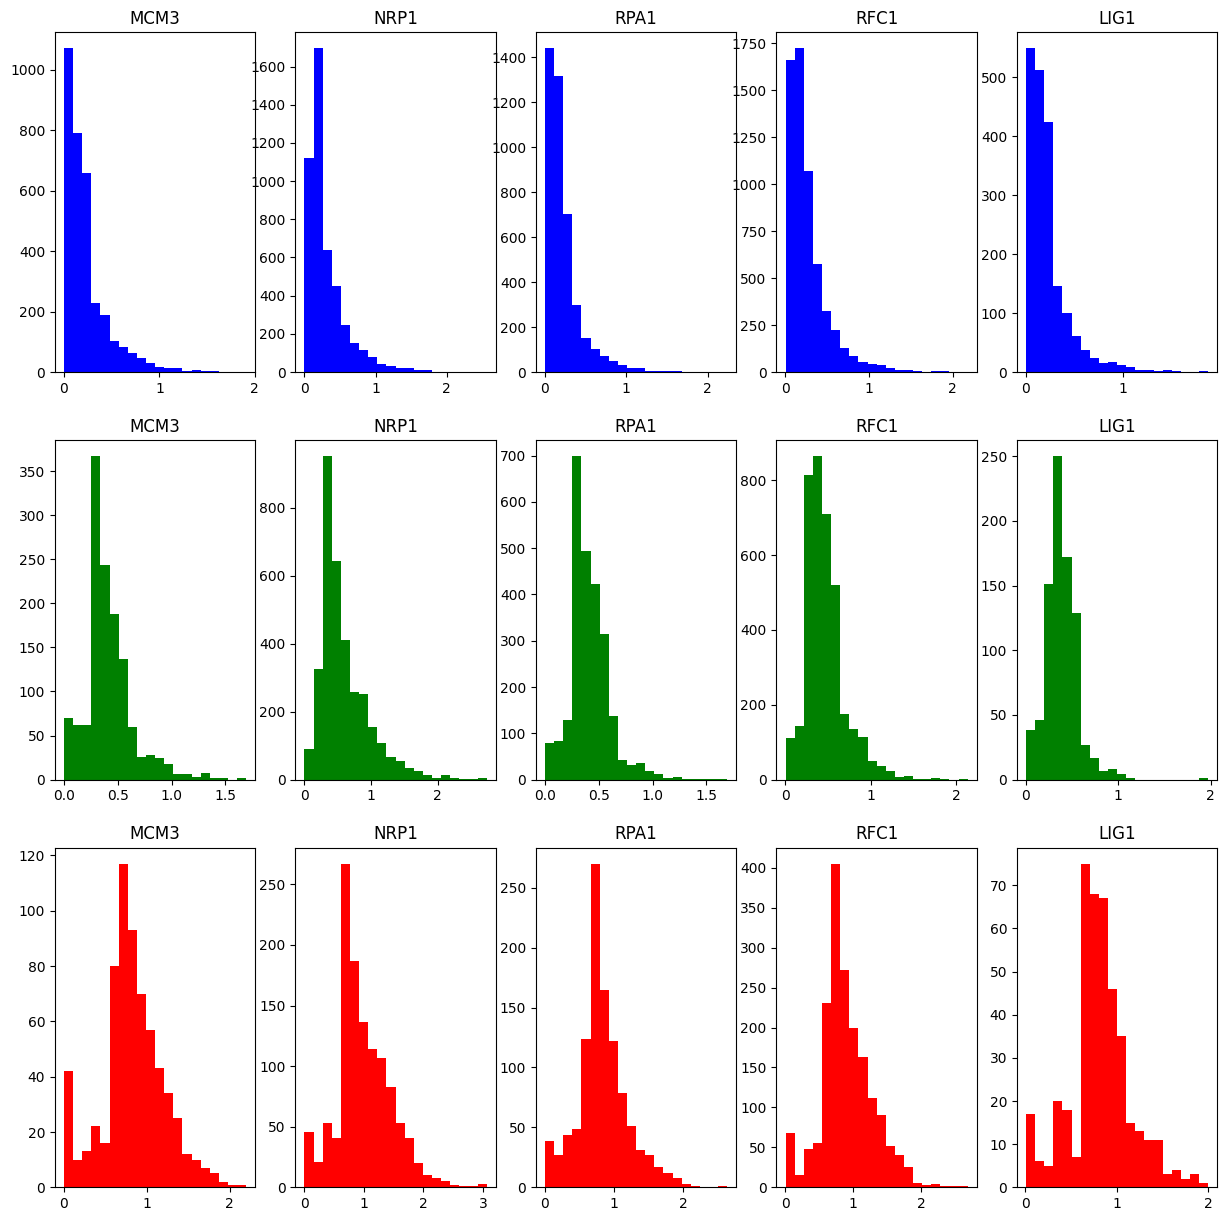

In [169]:
plt.figure(figsize=(15, 15))

for i, quant in enumerate(quant_km):
    quant_ = 0 if i == 0 else quant_km[i-1]
    # We use multiply because sparse matrices
    adata_quant = adata_duplication[(adata_km.X < quant).multiply(adata_km.X > quant_), : ]

    for j, gene in enumerate(duplication_genes):
        print(gene)
        adata_gene = adata_quant[:, adata_quant.var.feature_name == gene]
        plt.subplot(3, 5, i*len(duplication_genes) + j+1) # 3 rows, 5 columns ith plot
        plt.hist(adata_gene.X.data, bins=20, color=levels_quant[i])
        plt.title(gene)

plt.show()